# <center> Final training of Age estimation model </center>



In [1]:
!pip install GitPython
from git import Repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 14.1 MB/s 
     |████████████████████████████████| 62 kB 603 kB/s 


In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=a9d07961f6a128411c6947904d71963d142cece36619bf9feb58d9cb8421ebe3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json'

kaggle.json
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [14]:
HTTPS_REMOTE_URL = 'https://github.com/Bsingstad/ECG-age.git'
DEST_NAME = 'ecg_age'
cloned_repo = Repo.clone_from(HTTPS_REMOTE_URL, DEST_NAME)

In [4]:
!kaggle datasets download -d bjoernjostein/georgia-12lead-ecg-challenge-database
!kaggle datasets download -d bjoernjostein/st-petersburg-incart-12lead-arrhythmia-database
!kaggle datasets download -d bjoernjostein/china-12lead-ecg-challenge-database
!kaggle datasets download -d bjoernjostein/china-physiological-signal-challenge-in-2018
!kaggle datasets download -d erarayamorenzomuten/chapmanshaoxing-12lead-ecg-database
!kaggle datasets download -d erarayamorenzomuten/ningbo-first-hospital-12lead-ecg-database

!kaggle datasets download -d bjoernjostein/physionet-challenge-2021-snomed-mappings

 99% 479M/483M [00:16<00:00, 32.4MB/s]
100% 483M/483M [00:17<00:00, 29.6MB/s]
100% 564M/564M [00:19<00:00, 34.7MB/s]
100% 564M/564M [00:19<00:00, 30.2MB/s]
 99% 401M/406M [00:14<00:00, 36.3MB/s]
100% 406M/406M [00:14<00:00, 29.1MB/s]
100% 822M/824M [00:27<00:00, 35.7MB/s]
100% 824M/824M [00:27<00:00, 31.8MB/s]
 99% 543M/547M [00:18<00:00, 37.1MB/s]
100% 547M/547M [00:18<00:00, 30.9MB/s]
100% 1.78G/1.78G [00:59<00:00, 28.5MB/s]
100% 1.78G/1.78G [00:59<00:00, 31.9MB/s]
  0% 0.00/4.13k [00:00<?, ?B/s]
100% 4.13k/4.13k [00:00<00:00, 3.80MB/s]


In [5]:
import os, zipfile

dir_name = "./"
extension = ".zip"
 
os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [8]:
import shutil
import os
os.mkdir("/content/traindata/")
sources = ['Training_2/',  'Training_StPetersburg/','Training_WFDB/','WFDB_ChapmanShaoxing/', 'WFDB_Ningbo/', "WFDB/"]
dest1 = '/content/traindata/'


for s in sources:
  files = os.listdir(s)
  for f in files:
      shutil.move(s+f, dest1)

In [9]:
!kaggle datasets download -d bjoernjostein/ptbxl-electrocardiography-database

100% 1.35G/1.35G [00:47<00:00, 34.9MB/s]
100% 1.35G/1.35G [00:47<00:00, 30.5MB/s]


In [10]:
import os, zipfile

dir_name = "./"
extension = ".zip"
 
os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [11]:
import shutil
import os
os.mkdir("/content/testdata")
sources = ["WFDB/"]
dest1 = '/content/testdata/'


for s in sources:
  files = os.listdir(s)
  for f in files:
      shutil.move(s+f, dest1)

In [15]:
from ecg_age.src.helpers.helpers import *
from ecg_age.src.models.models import *

In [17]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tqdm
from scipy import signal
from tensorflow import keras
#from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload
%reload_ext autoreload
sns.set_style("dark")

In [29]:
######################################################
print("Collecting labels, ECG filenames and metadata...")
gender, age, labels, ecg_len, ecg_filenames = import_key_data("/content/testdata/") #testdata
ecg_filenames = np.asarray(ecg_filenames)
age = np.asarray(age)
gender = np.asarray(gender)
ecg_len = np.asarray(ecg_len)
labels = np.asarray(labels)
print(f"Total number of patients found: {len(age)}")

100%|██████████| 43674/43674 [00:49<00:00, 888.88it/s] 

Total number of patients found: 21837


In [30]:
#####################################################
print("remove all ECGs not equal to 10 seconds")
age, gender,ecg_filenames, labels = only_ten_sec(ecg_len, age, gender, ecg_filenames, labels)

remove all ECGs not equal to 10 seconds


In [31]:
print("remove all ECGs with missing values in gender or age")
ecg_filenames, gender, age, labels = remove_nan_and_unknown_values(ecg_filenames, gender, age, labels)

remove all ECGs with missing values in gender or age


In [32]:
age = clean_up_age_data(age)
gender = clean_up_gender_data(gender)

print(f"Total number of patients left after data cleaning: {len(age)}")

Total number of patients left after data cleaning: 21748


In [33]:
print("Select ECGs from males or females")
gender_choice = "both"

if gender_choice == "female":
    gender, age, ecg_filenames, labels = male_or_female(gender, age, ecg_filenames, labels, g="female")
elif gender_choice == "male":
    gender, age, ecg_filenames, labels = male_or_female(gender, age, ecg_filenames, labels, g="male")
else:
    print("Train on both male and female")
    pass

Select ECGs from males or females
Train on both male and female


In [34]:
test_age = age

In [27]:
train_age = age

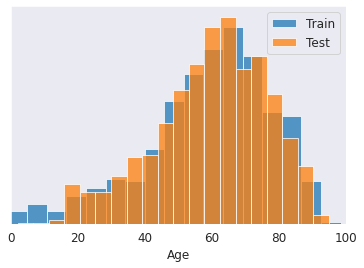

In [62]:
plt.hist(train_age,density=True, bins=20,alpha=0.75, label="Train")
plt.hist(test_age,density=True, bins=20, alpha=0.75, label="Test")
plt.xlim(0,100)
plt.xlabel("Age",fontsize=12)
plt.yticks([])
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.savefig("normalized_distribution.png",dpi=300)
plt.show()

In [47]:
from scipy import stats
stats.kstest(test_age,"norm")

KstestResult(statistic=0.9998303850392042, pvalue=0.0)

In [48]:
from scipy import stats
stats.kstest(train_age,"norm")

KstestResult(statistic=0.9957395359016258, pvalue=0.0)

In [49]:
from scipy import stats
stats.kstest(train_age,train_age)

KstestResult(statistic=0.0, pvalue=1.0)

In [ ]:
print(f"Total number of patients left after selection and data cleaning: {len(age)}")

In [ ]:
#TODO: update this acording to the optimal learning rate schedule found in hyperparameter opt.
def scheduler(epoch, lr):
    if epoch == 10:
        return lr * 0.1
    elif epoch == 15:
        return lr * 0.1
    elif epoch == 20:
        return lr * 0.1
    else:
        return lr

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [ ]:
model_name = "attia" # or "inception"

In [ ]:
samp_freq = 100
time = 10
num_leads = 12
batchsize = 16
epoch = 20
mae_score_total = []

print("Training model...")

#Chose model:
if model_name == "attia":
    model = attia_model(samp_freq, time, num_leads)
elif model_name == "inception":
    model = build_model((samp_freq*time,num_leads), 1)
model.fit(x=shuffle_batch_generator_age(batch_size=batchsize, gen_x=generate_X_age(ecg_filenames,samp_freq=samp_freq,num_leads=num_leads), gen_y=generate_y_age(age),num_leads=num_leads, time=time, samp_freq=samp_freq), epochs=epoch, 
            steps_per_epoch=(len(ecg_filenames)/batchsize), 
            verbose = 1, 
            callbacks=[lr_schedule]
            )

Training model...
Epoch 1/20
1083/1083 [==============================] - 143s 119ms/step - loss: 1342.2295 - mean_absolute_error: 29.7201 - val_loss: 214.4473 - val_mean_absolute_error: 11.5169 - lr: 0.0010
Epoch 2/20
1083/1083 [==============================] - 60s 56ms/step - loss: 238.8643 - mean_absolute_error: 12.0604 - val_loss: 179.4969 - val_mean_absolute_error: 10.3433 - lr: 0.0010
Epoch 3/20
1083/1083 [==============================] - 60s 55ms/step - loss: 220.2294 - mean_absolute_error: 11.5442 - val_loss: 221.8054 - val_mean_absolute_error: 11.8596 - lr: 0.0010
Epoch 4/20
1083/1083 [==============================] - 61s 56ms/step - loss: 209.3514 - mean_absolute_error: 11.2443 - val_loss: 166.7784 - val_mean_absolute_error: 10.0193 - lr: 0.0010
Epoch 5/20
1083/1083 [==============================] - 64s 60ms/step - loss: 200.7987 - mean_absolute_error: 10.9663 - val_loss: 196.4565 - val_mean_absolute_error: 10.7758 - lr: 0.0010
Epoch 6/20
1084/1083 [======================

In [ ]:
model.save_weights("model_weights_" + model_name + gender_choice + ".h5")